In [1]:
import ee
import pandas as pd
from google.colab import drive

# Google Drive einbinden
drive.mount('/content/drive')

ee.Authenticate()
ee.Initialize(project= 'deepalpine')

input_path = '/content/drive/MyDrive/testNaturgefahren/landslides_WITH_NEW_RAIN.csv'
df = pd.read_csv(input_path)

output_path = '/content/drive/MyDrive/testNaturgefahren/landslides_PROJEKTION_2100.csv'

print(f"Datei geladen. Erstelle jetzt Vorhersagen für {len(df)} Punkte...")

# 3. Speichern als neue Datei
df.to_csv(output_path, index=False)
print(f"Fertig! Die neue Datei wurde hier gespeichert: {output_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Datei geladen. Erstelle jetzt Vorhersagen für 668 Punkte...
Fertig! Die neue Datei wurde hier gespeichert: /content/drive/MyDrive/testNaturgefahren/landslides_PROJEKTION_2100.csv


In [8]:
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from google.colab import drive

# Drive einbinden
drive.mount('/content/drive')

# Pfade definieren
url = "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp126/wc2.1_30s_prec_MPI-ESM1-2-HR_ssp126_2081-2100.tif"
local_tif = "/content/global_data.tif"
save_path = '/content/drive/MyDrive/testNaturgefahren/Suedtirol_2100_1km'

if not os.path.exists(save_path):
    os.makedirs(save_path)

# Südtirol Bounding Box
bbox = box(10.3, 46.2, 12.5, 47.1)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

# 1. Download der TIF-Datei
print("Starte Download der TIF-Datei... Bitte warten.")
# -O speichert es unter dem definierten Namen
os.system(f"wget -c {url} -O {local_tif}")

# 2. Prüfen, ob der Download erfolgreich war
if os.path.exists(local_tif) and os.path.getsize(local_tif) > 0:
    print(f"Download fertig ({os.path.getsize(local_tif) / 1024**3:.2f} GB). Beginne mit dem Zuschneiden.")

    with rasterio.open(local_tif) as src:
        bands = src.count
        print(f"Datei hat {bands} Bänder (Monate).")

        for i in range(1, bands + 1):
            out_image, out_transform = mask(src, geo.geometry, crop=True, indexes=i)

            # Metadaten für die kleine Datei vorbereiten
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "count": 1 # Nur ein Band pro Monatsspeicherung
            })

            output_filename = f"{save_path}/prec_2100_month_{i:02d}.tif"
            with rasterio.open(output_filename, "w", **out_meta) as dest:
                dest.write(out_image)
            print(f"Monat {i} für Südtirol gespeichert.")

    os.remove(local_tif)
    print("\n fertig gelöscht")
else:
    print("Fehler: Die Datei konnte nicht geladen werden oder ist leer.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starte Download der TIF-Datei... Bitte warten.
Download fertig (20.86 GB). Beginne mit dem Zuschneiden.
Datei hat 12 Bänder (Monate).


IndexError: tuple index out of range

In [9]:
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from google.colab import drive

drive.mount('/content/drive')

local_tif = "/content/global_data.tif"
save_path = '/content/drive/MyDrive/testNaturgefahren/Suedtirol_2100_1km'

if not os.path.exists(save_path):
    os.makedirs(save_path)

# Bounding Box für Südtirol
bbox = box(10.3, 46.2, 12.5, 47.1)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

# Öffne die bereits heruntergeladene Datei
if os.path.exists(local_tif):
    with rasterio.open(local_tif) as src:
        print(f"Starte Zuschnitt für {src.count} Monate (Bänder)...")

        # Alle Bänder gleichzeitig zuschneiden (erzeugt 3D-Array: Bänder, Höhe, Breite)
        out_image, out_transform = mask(src, geo.geometry, crop=True)

        # Grundgerüst für Metadaten kopieren
        out_meta = src.meta.copy()

        for i in range(1, src.count + 1):
            # Index i-1 für den Zugriff auf das Array
            band_data = out_image[i-1]

            # Metadaten für die einzelne Datei aktualisieren
            # band_data ist 2D, daher shape[0]=Höhe, shape[1]=Breite
            out_meta.update({
                "driver": "GTiff",
                "height": band_data.shape[0],
                "width": band_data.shape[1],
                "transform": out_transform,
                "count": 1
            })

            output_filename = f"{save_path}/prec_2100_month_{i:02d}.tif"

            # Monatsspezifische Datei schreiben
            with rasterio.open(output_filename, "w", **out_meta) as dest:
                dest.write(band_data, 1)

            print(f"Monat {i} erfolgreich in Südtirol-Ordner gespeichert.")

    # Lokale Datei nach Erfolg löschen
    os.remove(local_tif)
    print("erfolgreich gelöscht")
else:
    print("Fehler")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starte Zuschnitt für 12 Monate (Bänder)...
Monat 1 erfolgreich in Südtirol-Ordner gespeichert.
Monat 2 erfolgreich in Südtirol-Ordner gespeichert.
Monat 3 erfolgreich in Südtirol-Ordner gespeichert.
Monat 4 erfolgreich in Südtirol-Ordner gespeichert.
Monat 5 erfolgreich in Südtirol-Ordner gespeichert.
Monat 6 erfolgreich in Südtirol-Ordner gespeichert.
Monat 7 erfolgreich in Südtirol-Ordner gespeichert.
Monat 8 erfolgreich in Südtirol-Ordner gespeichert.
Monat 9 erfolgreich in Südtirol-Ordner gespeichert.
Monat 10 erfolgreich in Südtirol-Ordner gespeichert.
Monat 11 erfolgreich in Südtirol-Ordner gespeichert.
Monat 12 erfolgreich in Südtirol-Ordner gespeichert.

--- PROZESS ERFOLGREICH ABGESCHLOSSEN ---


In [10]:
import pandas as pd
import rasterio
import os
from google.colab import drive

drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/testNaturgefahren/landslides_PROJEKTION_2100.csv'
tiff_folder = '/content/drive/MyDrive/testNaturgefahren/Suedtirol_2100_1km'

# CSV laden
if not os.path.exists(csv_path):
    print("Fehler: CSV-Datei nicht gefunden!")
else:
    df = pd.read_csv(csv_path)
    print(f"Lese Daten für {len(df)} Punkte...")

    # 2. Durch alle 12 Monate iterieren
    for month in range(1, 13):
        # Dateinamen konstruieren
        tif_file = f"{tiff_folder}/prec_2100_month_{month:02d}.tif"
        col_name = f"Prec_2100_SSP126_M{month:02d}"

        if os.path.exists(tif_file):
            with rasterio.open(tif_file) as src:
                # Koordinaten-Liste erstellen (Longitude, Latitude)
                coords = [(row['Longitude'], row['Latitude']) for _, row in df.iterrows()]

                # Werte auslesen (sample gibt einen Generator zurück)
                # Wir nehmen den ersten Wert [0], da wir nur ein Band pro Datei haben
                values = [val[0] for val in src.sample(coords)]

                # In den DataFrame schreiben
                df[col_name] = values
                print(f"Monat {month:02d}: Daten extrahiert.")
        else:
            print(f"Datei für Monat {month} nicht gefunden: {tif_file}")

    # 3. Speichern
    df.to_csv(csv_path, index=False)
    print(f"\nFertig! Die Datei wurde aktualisiert: {csv_path}")
    print("CSV enthält jetzt 12 neue Spalten mit den monatlichen Regenmengen für 2100")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Lese Daten für 668 Punkte...
Monat 01: Daten extrahiert.
Monat 02: Daten extrahiert.
Monat 03: Daten extrahiert.
Monat 04: Daten extrahiert.
Monat 05: Daten extrahiert.
Monat 06: Daten extrahiert.
Monat 07: Daten extrahiert.
Monat 08: Daten extrahiert.
Monat 09: Daten extrahiert.
Monat 10: Daten extrahiert.
Monat 11: Daten extrahiert.
Monat 12: Daten extrahiert.

Fertig! Die Datei wurde aktualisiert: /content/drive/MyDrive/testNaturgefahren/landslides_PROJEKTION_2100.csv
Deine CSV enthält jetzt 12 neue Spalten mit den monatlichen Regenmengen für 2100.


In [11]:
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from google.colab import drive

drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/testNaturgefahren/Suedtirol_2100_SSP585_1km'
local_tif = "/content/global_data_ssp585.tif"
url = "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp585/wc2.1_30s_prec_MPI-ESM1-2-HR_ssp585_2081-2100.tif"

if not os.path.exists(save_path):
    os.makedirs(save_path)

# Bounding Box für Südtirol
bbox = box(10.3, 46.2, 12.5, 47.1)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

# 1. Download
print("Starte Download für SSP585 (ca. 21 GB)... Bitte Tab offen lassen.")
if not os.path.exists(local_tif):
    os.system(f"wget -c {url} -O {local_tif}")

# 2. Zuschneiden
if os.path.exists(local_tif) and os.path.getsize(local_tif) > 1000:
    print("Download erfolgreich. Starte Zuschnitt...")

    with rasterio.open(local_tif) as src:
        # Alle 12 Bänder (Monate) auf einmal maskieren
        out_image, out_transform = mask(src, geo.geometry, crop=True)
        out_meta = src.meta.copy()

        for i in range(1, src.count + 1):
            band_data = out_image[i-1]

            out_meta.update({
                "driver": "GTiff",
                "height": band_data.shape[0],
                "width": band_data.shape[1],
                "transform": out_transform,
                "count": 1
            })

            # Dateiname explizit mit 'ssp585' kennzeichnen
            output_filename = f"{save_path}/prec_2100_ssp585_month_{i:02d}.tif"

            with rasterio.open(output_filename, "w", **out_meta) as dest:
                dest.write(band_data, 1)
            print(f"Monat {i} (SSP585) gespeichert.")

    # Aufräumen
    os.remove(local_tif)
    print("SSP585 VERARBEITUNG ABGESCHLOSSEN")
else:
    print("Fehler beim Download")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starte Download für SSP585 (ca. 21 GB)... Bitte Tab offen lassen.
Download erfolgreich. Starte Zuschnitt...
Monat 1 (SSP585) gespeichert.
Monat 2 (SSP585) gespeichert.
Monat 3 (SSP585) gespeichert.
Monat 4 (SSP585) gespeichert.
Monat 5 (SSP585) gespeichert.
Monat 6 (SSP585) gespeichert.
Monat 7 (SSP585) gespeichert.
Monat 8 (SSP585) gespeichert.
Monat 9 (SSP585) gespeichert.
Monat 10 (SSP585) gespeichert.
Monat 11 (SSP585) gespeichert.
Monat 12 (SSP585) gespeichert.

--- SSP585 VERARBEITUNG ABGESCHLOSSEN ---


In [12]:
import pandas as pd
import rasterio
import os

csv_path = '/content/drive/MyDrive/testNaturgefahren/landslides_PROJEKTION_2100.csv'
tiff_folder = '/content/drive/MyDrive/testNaturgefahren/Suedtirol_2100_SSP585_1km'

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f"Lese SSP585-Werte für {len(df)} Punkte...")

    for month in range(1, 13):
        tif_file = f"{tiff_folder}/prec_2100_ssp585_month_{month:02d}.tif"
        col_name = f"Prec_2100_SSP585_M{month:02d}"

        if os.path.exists(tif_file):
            with rasterio.open(tif_file) as src:
                coords = [(row['Longitude'], row['Latitude']) for _, row in df.iterrows()]
                # Werte auslesen
                df[col_name] = [val[0] for val in src.sample(coords)]
                print(f"Monat {month:02d} hinzugefügt.")
        else:
            print(f"Warnung: Datei für Monat {month} fehlt.")

    df.to_csv(csv_path, index=False)
    print("Fertig! CSV enthält jetzt beide Szenarien (SSP126 und SSP585).")

Lese SSP585-Werte für 668 Punkte...
Monat 01 hinzugefügt.
Monat 02 hinzugefügt.
Monat 03 hinzugefügt.
Monat 04 hinzugefügt.
Monat 05 hinzugefügt.
Monat 06 hinzugefügt.
Monat 07 hinzugefügt.
Monat 08 hinzugefügt.
Monat 09 hinzugefügt.
Monat 10 hinzugefügt.
Monat 11 hinzugefügt.
Monat 12 hinzugefügt.

Fertig! CSV enthält jetzt beide Szenarien (SSP126 und SSP585).


In [13]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/testNaturgefahren/landslides_PROJEKTION_2100.csv'
df = pd.read_csv(csv_path)

print("Berechne Bioklimatische Variablen für", len(df), "Punkte...")

def calculate_bio_precip(row, scenario_prefix):
    """
    Berechnet BIO12, BIO13 und BIO15 für ein gegebenes Szenario.
    """
    # 1. Die 12 Monatswerte
    cols = [f"{scenario_prefix}_M{i:02d}" for i in range(1, 13)]

    # Existieren die Spalten?
    if not all(col in row.index for col in cols):
        return pd.Series([0, 0, 0])

    values = row[cols].values.astype(float)

    # 2. Berechnung
    bio12 = np.sum(values)           # Jahresniederschlag (Summe)
    bio13 = np.max(values)           # Nassester Monat (Maximum)

    # Saisonalität (Variationskoeffizient)
    # Formel: (Standardabweichung / Mittelwert) * 100
    mean_val = np.mean(values)
    if mean_val > 0:
        bio15 = (np.std(values) / mean_val) * 100
    else:
        bio15 = 0

    return pd.Series([round(bio12, 1), round(bio13, 1), round(bio15, 1)])

# Berechnung für SSP126
print("Verarbeite SSP126...")
new_cols_126 = df.apply(lambda row: calculate_bio_precip(row, "Prec_2100_SSP126"), axis=1)
new_cols_126.columns = ['BIO12_2100_SSP126', 'BIO13_2100_SSP126', 'BIO15_2100_SSP126']
df = pd.concat([df, new_cols_126], axis=1)

# Berechnung für SSP585
print("Verarbeite SSP585...")
new_cols_585 = df.apply(lambda row: calculate_bio_precip(row, "Prec_2100_SSP585"), axis=1)
new_cols_585.columns = ['BIO12_2100_SSP585', 'BIO13_2100_SSP585', 'BIO15_2100_SSP585']
df = pd.concat([df, new_cols_585], axis=1)

# Speichern
df.to_csv(csv_path, index=False)
print("\nFertig!")
print("Beispiel für den ersten Punkt:")
print(df[['BIO12_2100_SSP126', 'BIO12_2100_SSP585']].head(1))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Berechne Bioklimatische Variablen für 668 Punkte...
Verarbeite SSP126...
Verarbeite SSP585...

Fertig! Deine Tabelle ist jetzt komplett 'intelligent'.
Beispiel für den ersten Punkt:
   BIO12_2100_SSP126  BIO12_2100_SSP585
0             1169.0             1044.0


In [14]:
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
from google.colab import drive
import zipfile

drive.mount('/content/drive')

input_csv = '/content/drive/MyDrive/testNaturgefahren/landslides_WITH_NEW_RAIN.csv'
# neue Datei für das Training:
output_csv = '/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_COMPLETE.csv'

# Ordner für die Karten
save_folder = '/content/drive/MyDrive/testNaturgefahren/Suedtirol_Historical_Bio'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Bounding Box Südtirol
bbox = box(10.3, 46.2, 12.5, 47.1)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

# DOWNLOAD
# Das ist der Link für "Bioclimatic variables" (enthält Regen UND Temperatur)
# Auflösung: 30 seconds (ca. 1 km)
url = "https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_30s_bio.zip"
zip_file = "/content/worldclim_bio_historical.zip"

print("1. Lade historische WorldClim-Daten (Regen & Temp)...")
if not os.path.exists(zip_file):
    os.system(f"wget -q --show-progress -c {url} -O {zip_file}")
else:
    print("ZIP-Datei ist schon da (spart Zeit).")

# EXTRAKTION
# BIO1 = Jahresdurchschnittstemperatur
# BIO12 = Jahresniederschlag
# BIO13 = Niederschlag des nassesten Monats
# BIO15 = Saisonalität (Variation)
target_files = {
    'wc2.1_30s_bio_01.tif': 'BIO01_Historical_Temp',
    'wc2.1_30s_bio_12.tif': 'BIO12_Historical_Prec',
    'wc2.1_30s_bio_13.tif': 'BIO13_Historical_Prec',
    'wc2.1_30s_bio_15.tif': 'BIO15_Historical_Prec'
}

print("2. Schneide Südtirol aus den Weltkarten...")

final_tifs = {}

with zipfile.ZipFile(zip_file, 'r') as z:
    for original_name, new_col_name in target_files.items():
        # Datei aus ZIP holen
        z.extract(original_name, path="/content/temp_extract")
        input_path = f"/content/temp_extract/{original_name}"
        output_path = f"{save_folder}/{new_col_name}.tif"

        # Zuschneiden
        with rasterio.open(input_path) as src:
            out_image, out_transform = mask(src, geo.geometry, crop=True)
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })
            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(out_image)

        final_tifs[new_col_name] = output_path
        # Temporäre Datei löschen
        os.remove(input_path)
        print(f"  -> {new_col_name} bereit.")

# WERTE IN NEUE CSV SCHREIBEN
print("3. Erstelle die finale Trainingsdatei...")

if os.path.exists(input_csv):
    df = pd.read_csv(input_csv)
    print(f"Lese {len(df)} Zeilen ein...")

    # Koordinaten
    coords = [(row['Longitude'], row['Latitude']) for _, row in df.iterrows()]

    for col_name, tif_path in final_tifs.items():
        with rasterio.open(tif_path) as src:
            # Werte auslesen
            values = [x[0] for x in src.sample(coords)]
            df[col_name] = values
            print(f"  + Spalte '{col_name}' hinzugefügt.")

    # Speichern als neue Datei
    df.to_csv(output_csv, index=False)
    print(f"FERTIG!")
    print(f"{output_csv}")
    print("Diese Datei enthält jetzt:")
    print("- Die alten Regendaten (7d, 14d...)")
    print("- Historische Temperatur (BIO1)")
    print("- Historische Niederschlags-Trends (BIO12, 13, 15)")
else:
    print("fehler")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1. Lade historische WorldClim-Daten (Regen & Temp)...
2. Schneide Südtirol aus den Weltkarten...


KeyError: "There is no item named 'wc2.1_30s_bio_01.tif' in the archive"

In [15]:
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
from google.colab import drive
import zipfile

drive.mount('/content/drive')

input_csv = '/content/drive/MyDrive/testNaturgefahren/landslides_WITH_NEW_RAIN.csv'
output_csv = '/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_COMPLETE.csv'
save_folder = '/content/drive/MyDrive/testNaturgefahren/Suedtirol_Historical_Bio'
zip_file = "/content/worldclim_bio_historical.zip"

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Bounding Box
bbox = box(10.3, 46.2, 12.5, 47.1)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

target_files = {
    'wc2.1_30s_bio_1.tif': 'BIO01_Historical_Temp',
    'wc2.1_30s_bio_12.tif': 'BIO12_Historical_Prec',
    'wc2.1_30s_bio_13.tif': 'BIO13_Historical_Prec',
    'wc2.1_30s_bio_15.tif': 'BIO15_Historical_Prec'
}

print("Prüfe ZIP-Inhalt und starte Extraktion...")

if os.path.exists(zip_file):
    final_tifs = {}

    with zipfile.ZipFile(zip_file, 'r') as z:
        all_files = z.namelist()

        for original_name, new_col_name in target_files.items():
            if original_name in all_files:
                # Datei extrahieren
                z.extract(original_name, path="/content/temp_extract")
                input_path = f"/content/temp_extract/{original_name}"
                output_path = f"{save_folder}/{new_col_name}.tif"

                # Zuschneiden
                with rasterio.open(input_path) as src:
                    out_image, out_transform = mask(src, geo.geometry, crop=True)
                    out_meta = src.meta.copy()
                    out_meta.update({
                        "driver": "GTiff",
                        "height": out_image.shape[1],
                        "width": out_image.shape[2],
                        "transform": out_transform
                    })
                    with rasterio.open(output_path, "w", **out_meta) as dest:
                        dest.write(out_image)

                final_tifs[new_col_name] = output_path
                os.remove(input_path)
                print(f"  -> {new_col_name} erfolgreich erstellt.")
            else:
                print(f"WARNUNG: Konnte {original_name} nicht im ZIP finden. Die Datei heißt im ZIP wohl anders.")
                similar = [f for f in all_files if "bio" in f and "tif" in f]
                print(f"  Verfügbare Dateien sind: {similar[:5]}...")

    if os.path.exists(input_csv):
        print("\nSchreibe Daten in die neue CSV...")
        df = pd.read_csv(input_csv)
        coords = [(row['Longitude'], row['Latitude']) for _, row in df.iterrows()]

        for col_name, tif_path in final_tifs.items():
            with rasterio.open(tif_path) as src:
                values = [x[0] for x in src.sample(coords)]
                df[col_name] = values
                print(f"  + Spalte '{col_name}' eingetragen.")

        df.to_csv(output_csv, index=False)
        print(f"\nFERTIG! Neue Datei erstellt: {output_csv}")
    else:
        print("Fehler: Eingabe-CSV fehlt.")
else:
    print("Fehler: ZIP-Datei nicht gefunden.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Prüfe ZIP-Inhalt und starte Extraktion...
  -> BIO01_Historical_Temp erfolgreich erstellt.
  -> BIO12_Historical_Prec erfolgreich erstellt.
  -> BIO13_Historical_Prec erfolgreich erstellt.
  -> BIO15_Historical_Prec erfolgreich erstellt.

Schreibe Daten in die neue CSV...
  + Spalte 'BIO01_Historical_Temp' eingetragen.
  + Spalte 'BIO12_Historical_Prec' eingetragen.
  + Spalte 'BIO13_Historical_Prec' eingetragen.
  + Spalte 'BIO15_Historical_Prec' eingetragen.

FERTIG! Neue Datei erstellt: /content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_COMPLETE.csv


In [16]:
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
from google.colab import drive
import zipfile

drive.mount('/content/drive')

input_csv = '/content/drive/MyDrive/testNaturgefahren/landslides_WITH_NEW_RAIN.csv'
output_csv = '/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_COMPLETE.csv'
save_folder = '/content/drive/MyDrive/testNaturgefahren/Suedtirol_Historical_Bio'
zip_file = "/content/worldclim_bio_historical.zip"

if not os.path.exists(save_folder):
    os.makedirs(save_folder)

bbox = box(10.3, 46.2, 12.5, 47.1)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

target_files = {
    'wc2.1_30s_bio_1.tif': 'BIO01_Historical_Mean',  # Durchschnitt
    'wc2.1_30s_bio_5.tif': 'BIO05_Historical_Max',   # Wärmster Monat
    'wc2.1_30s_bio_6.tif': 'BIO06_Historical_Min',   # Kältester Monat
    'wc2.1_30s_bio_12.tif': 'BIO12_Historical_Prec', # Jahresregen
    'wc2.1_30s_bio_13.tif': 'BIO13_Historical_Prec', # Nassester Monat
    'wc2.1_30s_bio_15.tif': 'BIO15_Historical_Prec'  # Saisonalität
}

print("1. Extrahiere Historische Daten (inkl. Sommer/Winter-Extreme)...")

# Falls ZIP nicht da, lade es
url = "https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_30s_bio.zip"
if not os.path.exists(zip_file):
    os.system(f"wget -q -c {url} -O {zip_file}")

final_tifs = {}

with zipfile.ZipFile(zip_file, 'r') as z:
    all_files = z.namelist()
    for original_name, new_col_name in target_files.items():
        if original_name in all_files:
            z.extract(original_name, path="/content/temp_extract")
            input_path = f"/content/temp_extract/{original_name}"
            output_path = f"{save_folder}/{new_col_name}.tif"

            with rasterio.open(input_path) as src:
                out_image, out_transform = mask(src, geo.geometry, crop=True)
                out_meta = src.meta.copy()
                out_meta.update({"driver": "GTiff", "height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform})
                with rasterio.open(output_path, "w", **out_meta) as dest:
                    dest.write(out_image)

            final_tifs[new_col_name] = output_path
            os.remove(input_path)
            print(f"  -> {new_col_name} erstellt.")

print("2. Erstelle neue Trainings-CSV...")

if os.path.exists(input_csv):
    df = pd.read_csv(input_csv)
    coords = [(row['Longitude'], row['Latitude']) for _, row in df.iterrows()]

    for col_name, tif_path in final_tifs.items():
        with rasterio.open(tif_path) as src:
            values = [x[0] for x in src.sample(coords)]
            df[col_name] = values
            print(f"  + {col_name} hinzugefügt.")

    df.to_csv(output_csv, index=False)
    print(f"\nFERTIG!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1. Extrahiere Historische Daten (inkl. Sommer/Winter-Extreme)...
  -> BIO01_Historical_Mean erstellt.
  -> BIO05_Historical_Max erstellt.
  -> BIO06_Historical_Min erstellt.
  -> BIO12_Historical_Prec erstellt.
  -> BIO13_Historical_Prec erstellt.
  -> BIO15_Historical_Prec erstellt.
2. Erstelle neue Trainings-CSV...
  + BIO01_Historical_Mean hinzugefügt.
  + BIO05_Historical_Max hinzugefügt.
  + BIO06_Historical_Min hinzugefügt.
  + BIO12_Historical_Prec hinzugefügt.
  + BIO13_Historical_Prec hinzugefügt.
  + BIO15_Historical_Prec hinzugefügt.

FERTIG!


In [17]:
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
from google.colab import drive
import zipfile

drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/testNaturgefahren/landslides_PROJEKTION_2100.csv'
save_folder = '/content/drive/MyDrive/testNaturgefahren/Suedtirol_2100_Temp'

bbox = box(10.3, 46.2, 12.5, 47.1)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

urls = {
    "SSP126": "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp126/wc2.1_30s_bio_MPI-ESM1-2-HR_ssp126_2081-2100.zip",
    "SSP585": "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp585/wc2.1_30s_bio_MPI-ESM1-2-HR_ssp585_2081-2100.zip"
}

# BIO1 = Durchschnitt, BIO5 = Max Wärmster Monat, BIO6 = Min Kältester Monat
target_vars = {
    '01.tif': 'BIO01',
    '05.tif': 'BIO05',
    '06.tif': 'BIO06'
}

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    coords = [(row['Longitude'], row['Latitude']) for _, row in df.iterrows()]

    print("Aktualisiere Zukunftsszenarien mit saisonalen Temperaturen...")

    for scenario, url in urls.items():
        zip_name = f"/content/temp_{scenario}.zip"

        # Download (falls nicht da)
        if not os.path.exists(zip_name):
            print(f"  Lade {scenario}...")
            os.system(f"wget -q -c {url} -O {zip_name}")

        with zipfile.ZipFile(zip_name, 'r') as z:
            file_list = z.namelist()

            for suffix, var_name in target_vars.items():
                # Suche Datei, die auf z.B. '05.tif' endet
                found_file = next((f for f in file_list if f.endswith(suffix)), None)

                if found_file:
                    z.extract(found_file, path="/content/temp_extract")
                    input_tif = f"/content/temp_extract/{found_file}"

                    # Spaltenname z.B. BIO05_2100_SSP126
                    if var_name == 'BIO01':
                        final_col = f"{var_name}_2100_{scenario}_Mean"
                    elif var_name == 'BIO05':
                        final_col = f"{var_name}_2100_{scenario}_Max"
                    elif var_name == 'BIO06':
                        final_col = f"{var_name}_2100_{scenario}_Min"

                    with rasterio.open(input_tif) as src:
                        out_image, out_transform = mask(src, geo.geometry, crop=True)

                        # Metadaten für Memory-File
                        out_meta = src.meta.copy()
                        out_meta.update({"driver": "GTiff", "height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform})

                        # Temporäres TIF speichern
                        temp_small = f"/content/small_{var_name}.tif"
                        with rasterio.open(temp_small, "w", **out_meta) as dest:
                            dest.write(out_image)

                        # Jetzt Werte holen
                        with rasterio.open(temp_small) as small_src:
                            df[final_col] = [x[0] for x in small_src.sample(coords)]
                            print(f"    + {final_col} eingetragen.")

                    # Aufräumen
                    os.remove(input_tif)
                else:
                    print(f"WARNUNG: {var_name} in {scenario} nicht gefunden!")

    df.to_csv(csv_path, index=False)
    print("fertig; Durchschnitt, Sommer-Max und Winter-Min für 2100")

else:
    print("fehler")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Aktualisiere Zukunftsszenarien mit saisonalen Temperaturen...
  Lade SSP126...


BadZipFile: File is not a zip file

In [19]:
import os
import requests
import zipfile
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
from google.colab import drive
import shutil

drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/testNaturgefahren/landslides_PROJEKTION_2100.csv'
temp_folder = '/content/temp_download' # Lokaler Temp-Ordner in Colab (schnell)

if not os.path.exists(temp_folder):
    os.makedirs(temp_folder)

# Bounding Box Südtirol
bbox = box(10.3, 46.2, 12.5, 47.1)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

# Links zu den Modelldaten (MPI-ESM1-2-HR, 30 seconds resolution)
urls = {
    "SSP126": "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp126/wc2.1_30s_bio_MPI-ESM1-2-HR_ssp126_2081-2100.zip",
    "SSP585": "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp585/wc2.1_30s_bio_MPI-ESM1-2-HR_ssp585_2081-2100.zip"
}

# Durchschnitt (1), Max Sommer (5), Min Winter (6)
target_vars = {
    '01.tif': 'BIO01',
    '05.tif': 'BIO05',
    '06.tif': 'BIO06'
}

# weil vorher Download nicht funktioniert hat hat Gemini das gesagt, glaube nicht dass es daran lag aber ok
def smart_download(url, dest_path):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    print(f"Starte Download von {os.path.basename(url)}...")
    try:
        with requests.get(url, stream=True, headers=headers, timeout=60) as r:
            r.raise_for_status() # Fehler werfen, wenn Server blockt (403/404)
            total_size = int(r.headers.get('content-length', 0))

            with open(dest_path, 'wb') as f:
                downloaded = 0
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
                    downloaded += len(chunk)
                    # Einfacher Fortschritts-Indikator alle 100MB
                    if downloaded % (100 * 1024 * 1024) < 9000:
                        print(f"  ... {downloaded / (1024**3):.2f} GB geladen", end='\r')
        print(f"Download fertig.")
        return True
    except Exception as e:
        print(f"feehler beim Download: {e}")
        return False

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    coords = [(row['Longitude'], row['Latitude']) for _, row in df.iterrows()]
    print(f"Verarbeite {len(df)} Punkte für echte Zukunftsdaten...")

    for scenario, url in urls.items():
        zip_name = os.path.join(temp_folder, f"{scenario}.zip")

        # 1. Download
        if not os.path.exists(zip_name):
            success = smart_download(url, zip_name)
            if not success:
                print(f"Überspringe {scenario} wegen Download-Fehler.")
                continue

        # 2. Prüfen ob ZIP okay ist
        try:
            with zipfile.ZipFile(zip_name, 'r') as z:
                file_list = z.namelist()
                print(f"Entpacke relevante Daten für {scenario}...")

                for suffix, var_name in target_vars.items():
                    # Suche die Datei (endet auf 01.tif, 05.tif usw.)
                    found_file = next((f for f in file_list if f.endswith(suffix)), None)

                    if found_file:
                        # Extrahiere nur diese eine Datei
                        z.extract(found_file, path=temp_folder)
                        input_tif = os.path.join(temp_folder, found_file)

                        # Spaltenname (z.B. BIO05_2100_SSP126_Max)
                        col_suffix = "_Mean" if var_name == 'BIO01' else "_Max" if var_name == 'BIO05' else "_Min"
                        final_col = f"{var_name}_2100_{scenario}{col_suffix}"

                        # Zuschneiden & Lesen
                        with rasterio.open(input_tif) as src:
                            out_image, out_transform = mask(src, geo.geometry, crop=True)

                            # Temporäres kleines TIF
                            small_tif = os.path.join(temp_folder, f"small_{var_name}.tif")
                            out_meta = src.meta.copy()
                            out_meta.update({"driver": "GTiff", "height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform})

                            with rasterio.open(small_tif, "w", **out_meta) as dest:
                                dest.write(out_image)

                            # Werte sampeln
                            with rasterio.open(small_tif) as small_src:
                                vals = [x[0] for x in small_src.sample(coords)]
                                df[final_col] = vals
                                print(f"  -> {final_col} erfolgreich ausgelesen.")

                        # Aufräumen
                        if os.path.exists(input_tif): os.remove(input_tif)
                        if os.path.exists(small_tif): os.remove(small_tif)
                    else:
                        print(f"WARNUNG: {var_name} nicht im ZIP gefunden.")

            # Nach Erfolg das ZIP löschen, um Platz für das nächste Szenario zu machen
            os.remove(zip_name)
            print(f"ZIP für {scenario} gelöscht (Speicherplatz freigegeben).")

        except zipfile.BadZipFile:
            print(f"CRITICAL: Die Datei für {scenario} ist trotz Browser-Trick beschädigt.")
            print("Der Server bricht vermutlich die Verbindung ab.")

    # Speichern
    df.to_csv(csv_path, index=False)
    print("PROZESS ABGESCHLOSSEN")
    print(f"Tabelle gespeichert: {csv_path}")

else:
    print("CSV nicht gefunden.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Verarbeite 668 Punkte für echte Zukunftsdaten...
Starte Download von wc2.1_30s_bio_MPI-ESM1-2-HR_ssp126_2081-2100.zip...

FEHLER beim Download: 404 Client Error: Not Found for url: https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp126/wc2.1_30s_bio_MPI-ESM1-2-HR_ssp126_2081-2100.zip
Überspringe SSP126 wegen Download-Fehler.
Starte Download von wc2.1_30s_bio_MPI-ESM1-2-HR_ssp585_2081-2100.zip...

FEHLER beim Download: 404 Client Error: Not Found for url: https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp585/wc2.1_30s_bio_MPI-ESM1-2-HR_ssp585_2081-2100.zip
Überspringe SSP585 wegen Download-Fehler.

--- PROZESS ABGESCHLOSSEN ---
Tabelle gespeichert: /content/drive/MyDrive/testNaturgefahren/landslides_PROJEKTION_2100.csv


In [20]:
import requests
links = [
    "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp585/wc2.1_30s_tmax_MPI-ESM1-2-HR_ssp585_2081-2100.tif",
    "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp585/wc2.1_30s_tmin_MPI-ESM1-2-HR_ssp585_2081-2100.tif",
    "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp126/wc2.1_30s_tmax_MPI-ESM1-2-HR_ssp126_2081-2100.tif",
    "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp126/wc2.1_30s_tmin_MPI-ESM1-2-HR_ssp126_2081-2100.tif"
]

print("Starte Link-Test...\n")

headers = {'User-Agent': 'Mozilla/5.0'}

for url in links:
    filename = url.split("/")[-1]
    try:
        # head() fragt nur nach dem Status, lädt keine Daten
        r = requests.head(url, headers=headers, timeout=10)

        if r.status_code == 200:
            # Wenn Datei da ist, schauen wir auf die Größe (Content-Length)
            size_mb = int(r.headers.get('content-length', 0)) / (1024 * 1024)
            print(f"EXISTIERT: {filename}")
            print(f"   Größe: {size_mb:.2f} MB")
        else:
            print(f"FEHLER {r.status_code}: {filename} nicht gefunden.")

    except Exception as e:
        print(f"Verbindungsproblem bei {filename}: {e}")

print("Test beendet.")

Starte Link-Test (HEAD Request)...

✅ EXISTIERT: wc2.1_30s_tmax_MPI-ESM1-2-HR_ssp585_2081-2100.tif
   Größe: 4921.43 MB
✅ EXISTIERT: wc2.1_30s_tmin_MPI-ESM1-2-HR_ssp585_2081-2100.tif
   Größe: 4882.22 MB
✅ EXISTIERT: wc2.1_30s_tmax_MPI-ESM1-2-HR_ssp126_2081-2100.tif
   Größe: 4904.86 MB
✅ EXISTIERT: wc2.1_30s_tmin_MPI-ESM1-2-HR_ssp126_2081-2100.tif
   Größe: 4863.21 MB

Test beendet.


In [21]:
import os
import requests
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

csv_path = '/content/drive/MyDrive/testNaturgefahren/landslides_PROJEKTION_2100.csv'
temp_dir = '/content/temp_calc_final'

if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# Bounding Box Südtirol
bbox = box(10.3, 46.2, 12.5, 47.1)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

data_links = {
    "SSP585": {
        "tmax": "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp585/wc2.1_30s_tmax_MPI-ESM1-2-HR_ssp585_2081-2100.tif",
        "tmin": "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp585/wc2.1_30s_tmin_MPI-ESM1-2-HR_ssp585_2081-2100.tif"
    },
    "SSP126": {
        "tmax": "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp126/wc2.1_30s_tmax_MPI-ESM1-2-HR_ssp126_2081-2100.tif",
        "tmin": "https://geodata.ucdavis.edu/cmip6/30s/MPI-ESM1-2-HR/ssp126/wc2.1_30s_tmin_MPI-ESM1-2-HR_ssp126_2081-2100.tif"
    }
}

# Funktion: Große Datei laden, zuschneiden, löschen
def process_huge_tif(url, scenario, var_type):
    filename = url.split("/")[-1]
    local_big_path = os.path.join(temp_dir, filename)
    local_crop_path = os.path.join(temp_dir, f"CROP_{scenario}_{var_type}.tif")

    # Prüfen, ob Crop schon da ist
    if os.path.exists(local_crop_path):
        print(f"  -> Crop gefunden: {local_crop_path}")
        return local_crop_path

    print(f"\nStarte Download: {filename} (ca. 4.9 GB)")

    # Streaming Download mit Requests
    try:
        with requests.get(url, stream=True, timeout=120) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            downloaded = 0

            with open(local_big_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024*1024): # 1MB Chunks
                    if chunk:
                        f.write(chunk)
                        downloaded += len(chunk)
                        # Fortschrittsanzeige
                        if downloaded % (500 * 1024 * 1024) < 1050000:
                            gb = downloaded / (1024**3)
                            print(f"     ... {gb:.2f} GB geladen", end='\r')

        print("Download fertig. Schneide Südtirol aus...")

        # Zuschneiden
        with rasterio.open(local_big_path) as src:
            # Alle Bänder (12 Monate)
            out_image, out_transform = mask(src, geo.geometry, crop=True)
            out_meta = src.meta.copy()

            # Update Metadata für den Crop
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

            # Crop speichern
            with rasterio.open(local_crop_path, "w", **out_meta) as dest:
                dest.write(out_image)

        print(f"  -> Crop gespeichert. Lösche große Datei...")
        os.remove(local_big_path)
        return local_crop_path

    except Exception as e:
        print(f"\nFEHLER bei {filename}: {e}")
        if os.path.exists(local_big_path): os.remove(local_big_path)
        return None

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    # Koordinaten vorbereiten
    coords = [(row['Longitude'], row['Latitude']) for _, row in df.iterrows()]
    print(f"Verarbeite Daten für {len(df)} Punkte...")

    for scenario, types in data_links.items():
        print(f"\n=== SZENARIO {scenario} ===")

        # 1. TMAX verarbeiten
        crop_tmax = process_huge_tif(types['tmax'], scenario, 'tmax')
        if not crop_tmax: continue # Abbruch wenn Download fehlschlagt

        # 2. TMIN verarbeiten
        crop_tmin = process_huge_tif(types['tmin'], scenario, 'tmin')
        if not crop_tmin: continue

        # 3. Berechnen
        print(f"Berechne BIO Variablen für {scenario}...")

        with rasterio.open(crop_tmax) as src_max:
            tmax_data = src_max.read() # Shape: (12, H, W)

        with rasterio.open(crop_tmin) as src_min:
            tmin_data = src_min.read() # Shape: (12, H, W)

        # BIO5: Max Temp of Warmest Month (Maximum über alle 12 Tmax-Monate)
        bio5_grid = np.max(tmax_data, axis=0)

        # BIO6: Min Temp of Coldest Month (Minimum über alle 12 Tmin-Monate)
        bio6_grid = np.min(tmin_data, axis=0)

        # BIO1: Annual Mean Temp (Mittelwert der monatlichen Mittelwerte)
        # Monthly Mean = (Tmax + Tmin) / 2
        monthly_means = (tmax_data + tmin_data) / 2.0
        bio1_grid = np.mean(monthly_means, axis=0)

        results = {
            f"BIO01_2100_{scenario}_Mean": bio1_grid,
            f"BIO05_2100_{scenario}_Max": bio5_grid,
            f"BIO06_2100_{scenario}_Min": bio6_grid
        }

        with rasterio.open(crop_tmax) as src:
            meta = src.meta.copy()
            meta.update(count=1)

        for col_name, grid in results.items():
            temp_res_path = os.path.join(temp_dir, "temp_res.tif")
            with rasterio.open(temp_res_path, 'w', **meta) as dst:
                dst.write(grid, 1)

            with rasterio.open(temp_res_path) as res_src:
                vals = [x[0] for x in res_src.sample(coords)]
                df[col_name] = vals
                print(f"  -> {col_name} eingetragen.")

            os.remove(temp_res_path)


    # Speichern
    df.to_csv(csv_path, index=False)
    print("FERTIG!")
else:
    print("Fehler")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Verarbeite Daten für 668 Punkte...

=== SZENARIO SSP585 ===

Starte Download: wc2.1_30s_tmax_MPI-ESM1-2-HR_ssp585_2081-2100.tif (ca. 4.9 GB)

Download fertig. Schneide Südtirol aus...
  -> Crop gespeichert. Lösche große Datei...

Starte Download: wc2.1_30s_tmin_MPI-ESM1-2-HR_ssp585_2081-2100.tif (ca. 4.9 GB)

Download fertig. Schneide Südtirol aus...
  -> Crop gespeichert. Lösche große Datei...
Berechne BIO Variablen für SSP585...
  -> BIO01_2100_SSP585_Mean eingetragen.
  -> BIO05_2100_SSP585_Max eingetragen.
  -> BIO06_2100_SSP585_Min eingetragen.

=== SZENARIO SSP126 ===

Starte Download: wc2.1_30s_tmax_MPI-ESM1-2-HR_ssp126_2081-2100.tif (ca. 4.9 GB)

Download fertig. Schneide Südtirol aus...
  -> Crop gespeichert. Lösche große Datei...

Starte Download: wc2.1_30s_tmin_MPI-ESM1-2-HR_ssp126_2081-2100.tif (ca. 4.9 GB)

Download fertig. Schneide Südtirol aus.

In [22]:
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
import numpy as np
import zipfile
import math
from google.colab import drive

drive.mount('/content/drive')

train_csv = '/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_COMPLETE.csv'
# Zukunfts-Datei
proj_csv = '/content/drive/MyDrive/testNaturgefahren/landslides_PROJEKTION_2100.csv'

temp_dir = '/content/temp_topo'
if not os.path.exists(temp_dir): os.makedirs(temp_dir)

# Bounding Box Südtirol
bbox = box(10.0, 46.0, 13.0, 47.5)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

# Elevation
url = "https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_30s_elev.zip"
zip_path = f"{temp_dir}/elev.zip"

print("1. Lade Höhenmodell (WorldClim/SRTM)...")
if not os.path.exists(zip_path):
    os.system(f"wget -q -c {url} -O {zip_path}")

def calculate_slope_and_elevation(csv_path, elev_tif_path):
    """Liest Elevation und berechnet Slope (Grad) für eine CSV."""
    df = pd.read_csv(csv_path)
    coords = [(row['Longitude'], row['Latitude']) for _, row in df.iterrows()]

    with rasterio.open(elev_tif_path) as src:
        # Elevation auslesen
        df['Elevation'] = [x[0] for x in src.sample(coords)]

        # Slope Berechnung
        out_image, out_transform = mask(src, geo.geometry, crop=True)
        data = out_image[0].astype('float32')

        # Pixelgröße in Grad (aus Transform)
        res_x = out_transform[0] # z.B. 0.008333
        res_y = -out_transform[4] # z.B. 0.008333

        # Umrechnung Grad -> Meter (bei ca. 46.5 Grad Breite)
        # 1 Grad Latitude ~= 111132 Meter
        # 1 Grad Longitude ~= 111132 * cos(lat) Meter
        lat_mean = 46.5 * (math.pi / 180)
        scale_x = 111132 * math.cos(lat_mean) * res_x
        scale_y = 111132 * res_y

        # Gradienten berechnen (np.gradient gibt Differenz pro Pixel)
        dy, dx = np.gradient(data)

        # Gradienten in Meter umrechnen (Höhenänderung pro Meter Distanz)
        # dx ist Änderung pro Spalte, dy pro Zeile
        slope_rad = np.arctan(np.sqrt((dx/scale_x)**2 + (dy/scale_y)**2))
        slope_deg = np.degrees(slope_rad)

        # Slope als temporäres TIF speichern, um zu samplen (genauer als Index-Matching)
        meta = src.meta.copy()
        meta.update({
            "driver": "GTiff",
            "height": data.shape[0],
            "width": data.shape[1],
            "transform": out_transform
        })

        slope_tif = f"{temp_dir}/temp_slope.tif"
        with rasterio.open(slope_tif, 'w', **meta) as dst:
            dst.write(slope_deg, 1)

        with rasterio.open(slope_tif) as s_src:
            df['Slope'] = [x[0] for x in s_src.sample(coords)]

    return df

with zipfile.ZipFile(zip_path, 'r') as z:
    tif_name = [f for f in z.namelist() if f.endswith('.tif')][0]
    z.extract(tif_name, path=temp_dir)
    elev_tif_full = f"{temp_dir}/{tif_name}"

    # 1. Trainingsdaten aktualisieren
    if os.path.exists(train_csv):
        print(f"Aktualisiere Training ({train_csv})...")
        df_train = calculate_slope_and_elevation(train_csv, elev_tif_full)
        df_train.to_csv(train_csv, index=False)
        print("  -> Elevation & Slope (Grad) eingefügt.")

    # 2. Zukunftsdaten aktualisieren
    if os.path.exists(proj_csv):
        print(f"Aktualisiere Zukunft ({proj_csv})...")
        df_proj = calculate_slope_and_elevation(proj_csv, elev_tif_full)

        # Spalten-Mapping für Zukunft (Vorbereitung Prediction)
        # Damit der Random Forest die Spalten wiedererkennt
        rename_map_126 = {
            'BIO01_2100_SSP126_Mean': 'BIO01_Historical_Mean',
            'BIO05_2100_SSP126_Max':  'BIO05_Historical_Max',
            'BIO06_2100_SSP126_Min':  'BIO06_Historical_Min',
            'BIO12_2100_SSP126':      'BIO12_Historical_Prec',
            'BIO13_2100_SSP126':      'BIO13_Historical_Prec',
            'BIO15_2100_SSP126':      'BIO15_Historical_Prec'
        }

        rename_map_585 = {
            'BIO01_2100_SSP585_Mean': 'BIO01_Historical_Mean',
            'BIO05_2100_SSP585_Max':  'BIO05_Historical_Max',
            'BIO06_2100_SSP585_Min':  'BIO06_Historical_Min',
            'BIO12_2100_SSP585':      'BIO12_Historical_Prec',
            'BIO13_2100_SSP585':      'BIO13_Historical_Prec',
            'BIO15_2100_SSP585':      'BIO15_Historical_Prec'
        }

        df_proj.to_csv(proj_csv, index=False)

        # SSP126
        df_126 = df_proj.copy().rename(columns=rename_map_126)
        cols_126 = ['Latitude', 'Longitude', 'Elevation', 'Slope'] + list(rename_map_126.values())
        # Nur behalten was da ist
        df_126 = df_126[[c for c in cols_126 if c in df_126.columns]]
        df_126.to_csv('/content/drive/MyDrive/testNaturgefahren/PREDICT_SSP126_READY.csv', index=False)

        # SSP585
        df_585 = df_proj.copy().rename(columns=rename_map_585)
        cols_585 = ['Latitude', 'Longitude', 'Elevation', 'Slope'] + list(rename_map_585.values())
        df_585 = df_585[[c for c in cols_585 if c in df_585.columns]]
        df_585.to_csv('/content/drive/MyDrive/testNaturgefahren/PREDICT_SSP585_READY.csv', index=False)

        print("  -> Elevation & Slope eingefügt.")
        print("  -> Prediction-Dateien (SSP126 & SSP585) erstellt.")

print("\nFERTIG!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1. Lade Höhenmodell (WorldClim/SRTM)...
Aktualisiere Training (/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_COMPLETE.csv)...
  -> Elevation & Slope (Grad) eingefügt.
Aktualisiere Zukunft (/content/drive/MyDrive/testNaturgefahren/landslides_PROJEKTION_2100.csv)...
  -> Elevation & Slope eingefügt.
  -> Prediction-Dateien (SSP126 & SSP585) erstellt.

FERTIG!


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab import drive
import sys

drive.mount('/content/drive')

orig_train_path = '/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_COMPLETE.csv'
pred_126_path = '/content/drive/MyDrive/testNaturgefahren/PREDICT_SSP126_READY.csv'
pred_585_path = '/content/drive/MyDrive/testNaturgefahren/PREDICT_SSP585_READY.csv'

clean_train_output = '/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_CLEAN.csv'
result_126 = '/content/drive/MyDrive/testNaturgefahren/RESULT_Risk_Map_2100_SSP126.csv'
result_585 = '/content/drive/MyDrive/testNaturgefahren/RESULT_Risk_Map_2100_SSP585.csv'

# Features, die das Modell nutzen soll
features = [
    'Latitude', 'Longitude', 'Elevation', 'Slope',
    'BIO01_Historical_Mean', 'BIO05_Historical_Max', 'BIO06_Historical_Min',
    'BIO12_Historical_Prec', 'BIO13_Historical_Prec', 'BIO15_Historical_Prec'
]


if not pd.io.common.file_exists(orig_train_path):
    sys.exit(f"Fehler: Datei nicht gefunden {orig_train_path}")

df = pd.read_csv(orig_train_path)

# 1. Zielvariable erstellen (Text -> 0/1)
# Alles ist Gefahr (1), außer es steht explizit "No Rutschung" da
def map_risk(val):
    text = str(val).strip()
    if text == 'No Rutschung':
        return 0 # Sicher
    return 1 # Gefahr (Mure, Gleitung, etc.)

df['Target'] = df['MOVEMENT_D'].apply(map_risk)

counts = df['Target'].value_counts()
print(f"Verteilung der Klassen (0=Sicher, 1=Gefahr):\n{counts}")

if 0 not in counts:
    sys.exit("Keine 'No Rutschung' gefunden.")

# 2. Dings erstellen (Nur Features + Target)
# ohne Datum, UUID und Rainfall_7d
df_clean = df[features + ['Target']].copy()

# NaNs in Features (z.B. fehlender Slope) mit 0 füllen
df_clean[features] = df_clean[features].fillna(0)

# Speichern
df_clean.to_csv(clean_train_output, index=False)
print(f"Trainingsdatei gespeichert: {clean_train_output}")
print(f"   (Enthält nur noch: {list(df_clean.columns)})")


print("\n SCHRITT 2: TRAINING (RANDOM FOREST)")

X = df_clean[features]
y = df_clean['Target']

# Split: 80% Training, 20% Testen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell initialisieren (300 Bäume)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# Wie gut ist das Modell?
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"MODELL GENAUIGKEIT: {acc*100:.2f}%")

print("\nWas sind die wichtigsten Treiber für Rutschungen?")
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print(importances.head(5))


print("\nSCHRITT 3: PROGNOSE 2100")

def predict_scenario(input_csv, output_csv, name):
    print(f"Berechne Karte für {name}...")

    if not pd.io.common.file_exists(input_csv):
        print(f"Fehler: Input fehlt {input_csv}")
        return

    df_future = pd.read_csv(input_csv)

    # Sicherstellen, dass Slope/Elevation da sind (fillna 0 falls Lücken)
    X_future = df_future[features].fillna(0)

    # Wahrscheinlichkeit berechnen (0.0 bis 1.0)
    probs = rf.predict_proba(X_future)[:, 1]

    # Ins CSV schreiben
    df_future['Landslide_Probability'] = probs

    # Eine lesbare Klasse dazu
    df_future['Risk_Class'] = df_future['Landslide_Probability'].apply(
        lambda x: 'HOCH' if x >= 0.7 else ('MITTEL' if x >= 0.3 else 'NIEDRIG')
    )

    df_future.to_csv(output_csv, index=False)
    print(f"Karte erstellt: {output_csv}")

# Ausführen
predict_scenario(pred_126_path, result_126, "SSP126 (Optimistisch)")
predict_scenario(pred_585_path, result_585, "SSP585 (Pessimistisch)")

print("fertig!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
SCHRITT 1: DATEN BEREINIGEN & VORBEREITEN
Verteilung der Klassen (0=Sicher, 1=Gefahr):
Target
0    480
1    188
Name: count, dtype: int64
Trainingsdatei gespeichert: /content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_CLEAN.csv
   (Enthält nur noch: ['Latitude', 'Longitude', 'Elevation', 'Slope', 'BIO01_Historical_Mean', 'BIO05_Historical_Max', 'BIO06_Historical_Min', 'BIO12_Historical_Prec', 'BIO13_Historical_Prec', 'BIO15_Historical_Prec', 'Target'])

 SCHRITT 2: TRAINING (RANDOM FOREST)
MODELL GENAUIGKEIT: 82.84%

Was sind die wichtigsten Treiber für Rutschungen?
BIO01_Historical_Mean    0.138815
Elevation                0.134237
BIO05_Historical_Max     0.113305
Latitude                 0.107161
Longitude                0.098922
dtype: float64

SCHRITT 3: PROGNOSE 2100
Berechne Karte für SSP126 (Optimistisch)...
Karte erstellt: /content/drive/MyD

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from google.colab import drive

# drive.mount('/content/drive')

clean_train_path = '/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_CLEAN.csv'
result_126 = '/content/drive/MyDrive/testNaturgefahren/RESULT_Risk_Map_2100_SSP126_PRUNED.csv'
result_585 = '/content/drive/MyDrive/testNaturgefahren/RESULT_Risk_Map_2100_SSP585_PRUNED.csv'
pred_126_path = '/content/drive/MyDrive/testNaturgefahren/PREDICT_SSP126_READY.csv'
pred_585_path = '/content/drive/MyDrive/testNaturgefahren/PREDICT_SSP585_READY.csv'

# Features
features = [
    'Latitude', 'Longitude', 'Elevation', 'Slope',
    'BIO01_Historical_Mean', 'BIO05_Historical_Max', 'BIO06_Historical_Min',
    'BIO12_Historical_Prec', 'BIO13_Historical_Prec', 'BIO15_Historical_Prec'
]

# Daten laden
df = pd.read_csv(clean_train_path)
X = df[features].fillna(0)
y = df['Target']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("1. OVERFITTING??")
# Das alte Modell (ungebremst)
rf_old = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42)
rf_old.fit(X_train, y_train)

train_acc = rf_old.score(X_train, y_train)
test_acc = rf_old.score(X_test, y_test)

print(f"Altes Modell - Training Genauigkeit: {train_acc*100:.2f}%")
print(f"Altes Modell - Test Genauigkeit:     {test_acc*100:.2f}%")
diff = train_acc - test_acc
print(f"-> Unterschied: {diff*100:.2f} Prozentpunkte")

if diff > 0.10:
    print("Achtung: Hohes Overfitting! Modell lernt auswendig.")
else:
    print("Info: Overfitting hält sich in Grenzen.")


print("\n 2.: MODELL MIT PRUNING")
# Wir setzen Constraints
rf_pruned = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,        # Nicht tiefer als 10 Ebenen
    min_samples_leaf=4,  # Jedes Blatt muss mind. 4 Fälle abdecken (verhindert Ausreißer-Regeln)
    max_features='sqrt', # Standard, aber gut zu explizieren
    random_state=42
)
rf_pruned.fit(X_train, y_train)

train_acc_new = rf_pruned.score(X_train, y_train)
test_acc_new = rf_pruned.score(X_test, y_test)

print(f"Neues Modell - Training Genauigkeit: {train_acc_new*100:.2f}%")
print(f"Neues Modell - Test Genauigkeit:     {test_acc_new*100:.2f}%")

print("\n--- 3. NEUE KARTEN ERSTELLEN ---")
# Funktion für Vorhersage
def predict_scenario(input_csv, output_csv, name):
    if not pd.io.common.file_exists(input_csv): return
    df_future = pd.read_csv(input_csv)
    X_fut = df_future[features].fillna(0)

    # Wahrscheinlichkeiten
    probs = rf_pruned.predict_proba(X_fut)[:, 1]
    df_future['Landslide_Probability'] = probs

    # Klasse
    df_future['Risk_Class'] = df_future['Landslide_Probability'].apply(
        lambda x: 'HOCH' if x >= 0.7 else ('MITTEL' if x >= 0.3 else 'NIEDRIG')
    )

    df_future.to_csv(output_csv, index=False)
    print(f"Pruned Karte gespeichert: {output_csv}")

predict_scenario(pred_126_path, result_126, "SSP126_Pruned")
predict_scenario(pred_585_path, result_585, "SSP585_Pruned")

1. OVERFITTING??
Altes Modell - Training Genauigkeit: 100.00%
Altes Modell - Test Genauigkeit:     82.84%
-> Unterschied: 17.16 Prozentpunkte
WARNUNG: Hohes Overfitting! Modell lernt auswendig.

 2.: MODELL MIT PRUNING (BREMSEN)
Neues Modell - Training Genauigkeit: 95.51%
Neues Modell - Test Genauigkeit:     80.60%

--- 3. NEUE KARTEN ERSTELLEN ---
Pruned Karte gespeichert: /content/drive/MyDrive/testNaturgefahren/RESULT_Risk_Map_2100_SSP126_PRUNED.csv
Pruned Karte gespeichert: /content/drive/MyDrive/testNaturgefahren/RESULT_Risk_Map_2100_SSP585_PRUNED.csv


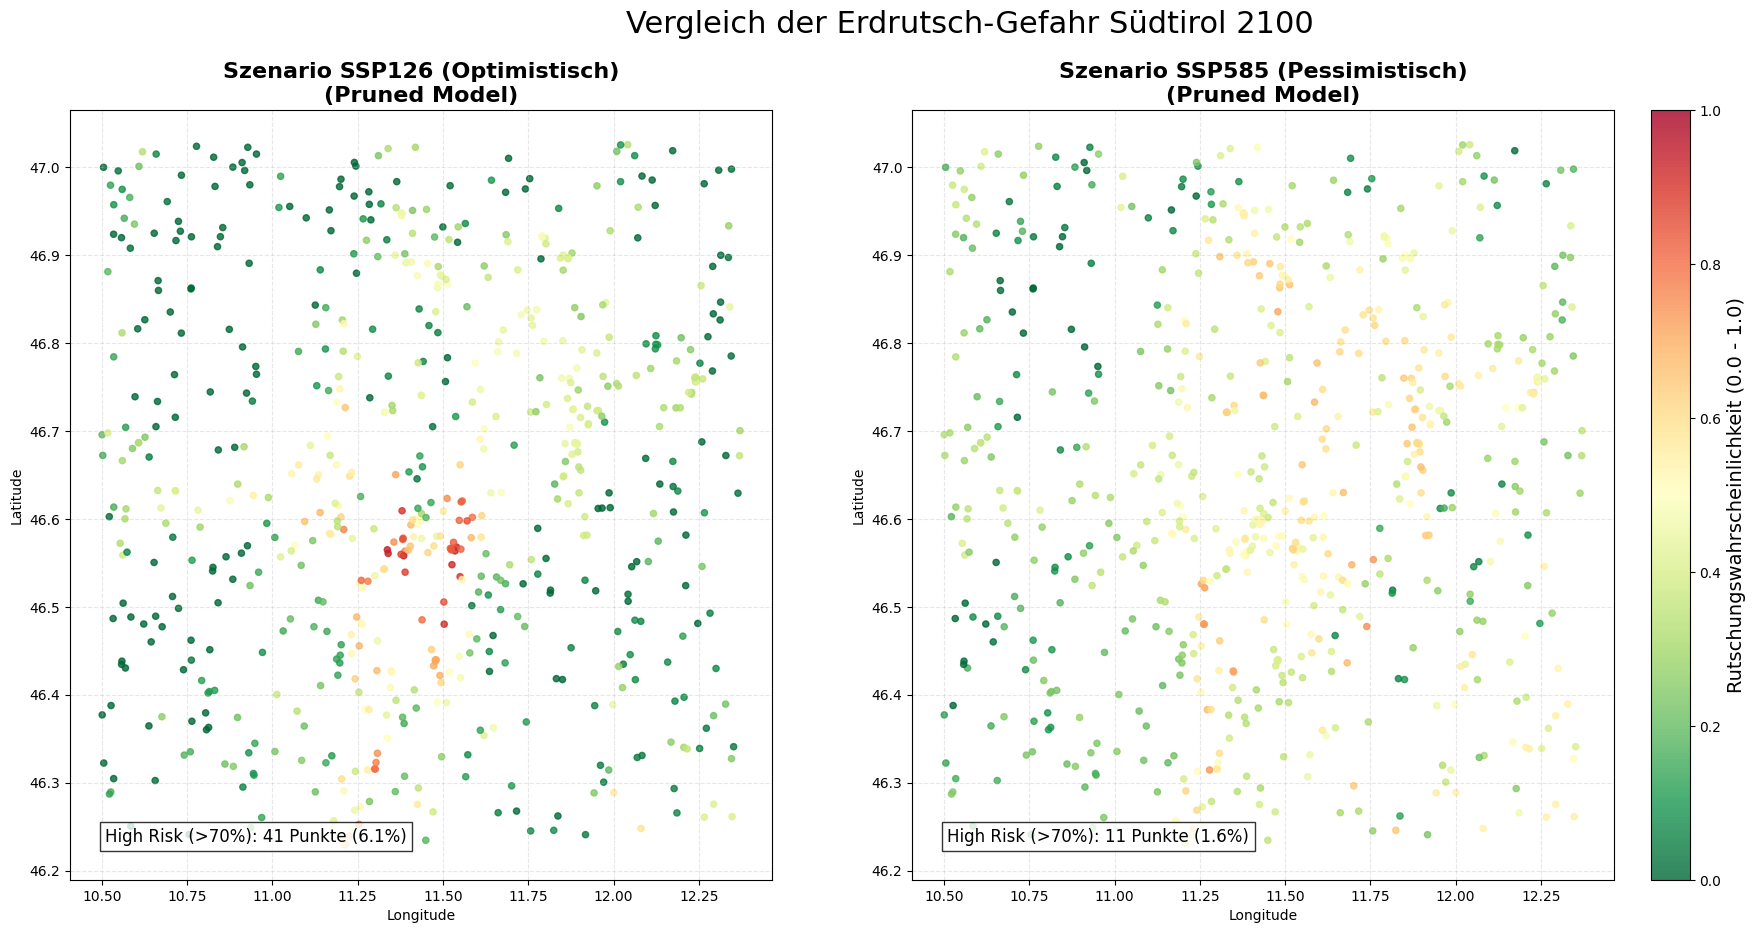


 DAS ERGEBNIS
Hochrisiko-Punkte im 'Best Case' (SSP126):  41
Hochrisiko-Punkte im 'Worst Case' (SSP585): 11
-> Differenz: -30 zusätzliche Gefahrenstellen durch extremen Klimawandel.


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_126 = '/content/drive/MyDrive/testNaturgefahren/RESULT_Risk_Map_2100_SSP126_PRUNED.csv'
file_585 = '/content/drive/MyDrive/testNaturgefahren/RESULT_Risk_Map_2100_SSP585_PRUNED.csv'

df_126 = pd.read_csv(file_126)
df_585 = pd.read_csv(file_585)

fig, axes = plt.subplots(1, 2, figsize=(24, 10))
cmap = "RdYlGn_r" # Grün=Sicher, Rot=Gefahr

def plot_map(ax, df, title):
    # Scatter Plot
    sc = ax.scatter(
        df['Longitude'],
        df['Latitude'],
        c=df['Landslide_Probability'],
        cmap=cmap,
        s=20,
        alpha=0.8,
        vmin=0, vmax=1
    )

    # Hintergrund (grob)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True, linestyle='--', alpha=0.3)

    # Statistik direkt im Plot
    n_high = df[df['Landslide_Probability'] > 0.7].shape[0]
    n_total = df.shape[0]
    percent = (n_high / n_total) * 100
    ax.text(0.05, 0.05, f"High Risk (>70%): {n_high} Punkte ({percent:.1f}%)",
            transform=ax.transAxes, fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8))

    return sc

# Karte 1
sc1 = plot_map(axes[0], df_126, "Szenario SSP126 (Optimistisch)\n(Pruned Model)")

# Karte 2
sc2 = plot_map(axes[1], df_585, "Szenario SSP585 (Pessimistisch)\n(Pruned Model)")

# Legende
cbar = fig.colorbar(sc1, ax=axes.ravel().tolist(), pad=0.02)
cbar.set_label("Rutschungswahrscheinlichkeit (0.0 - 1.0)", fontsize=14)

plt.suptitle("Vergleich der Erdrutsch-Gefahr Südtirol 2100", fontsize=22)
plt.show()

# ZAHLEN
high_126 = df_126[df_126['Landslide_Probability'] > 0.7].shape[0]
high_585 = df_585[df_585['Landslide_Probability'] > 0.7].shape[0]

print(f"\n DAS ERGEBNIS")
print(f"Hochrisiko-Punkte im 'Best Case' (SSP126):  {high_126}")
print(f"Hochrisiko-Punkte im 'Worst Case' (SSP585): {high_585}")
print(f"-> Differenz: {high_585 - high_126} zusätzliche Gefahrenstellen durch extremen Klimawandel.")

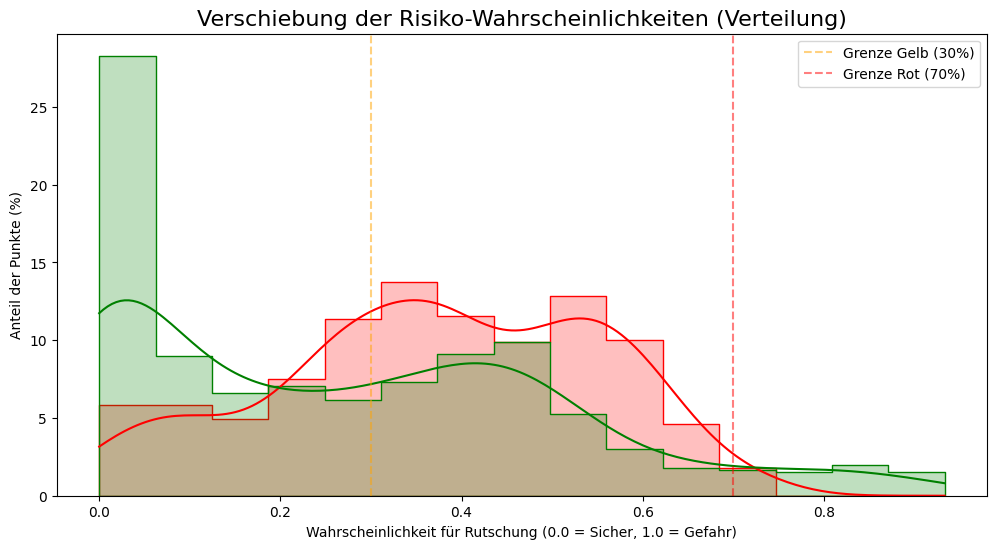


 DETAILLIERTE ZAHLEN
                   SSP126  SSP585
Kategorie                        
1. Niedrig (Grün)     369     221
2. Mittel (Gelb)      258     436
3. Hoch (Rot)          41      11


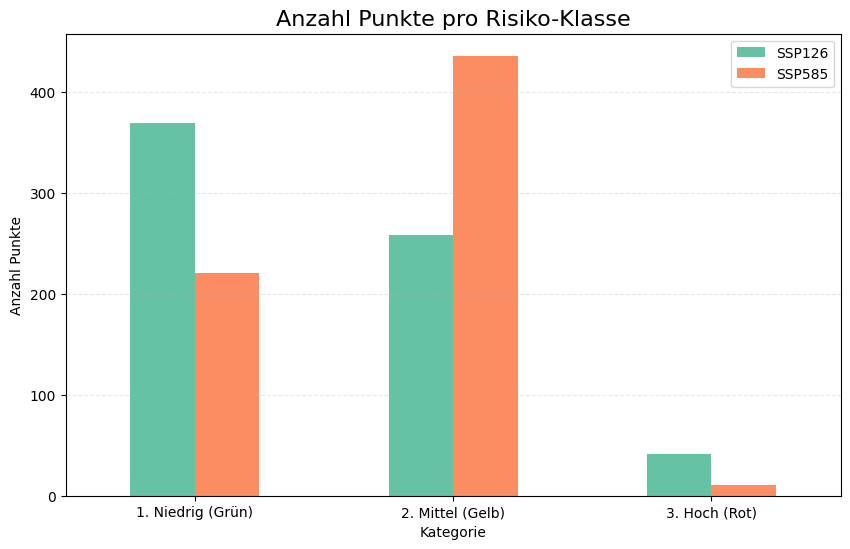


Veränderung der gelben Punkte (Mittel): +178
-> Viele rote Punkte sind nicht 'sicher' geworden, sondern nur 'unsicherer' (Gelb).
   Das Risiko ist also nicht weg, es ist nur diffuser geworden.


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path_126 = '/content/drive/MyDrive/testNaturgefahren/RESULT_Risk_Map_2100_SSP126_PRUNED.csv'
path_585 = '/content/drive/MyDrive/testNaturgefahren/RESULT_Risk_Map_2100_SSP585_PRUNED.csv'

df_126 = pd.read_csv(path_126)
df_585 = pd.read_csv(path_585)

# Spalte "Szenario" hinzufügen, um sie gleich gemeinsam zu plotten
df_126['Szenario'] = 'SSP126 (Optimistisch)'
df_585['Szenario'] = 'SSP585 (Pessimistisch)'

df_all = pd.concat([df_126, df_585])

# 1. DAS HISTOGRAMM
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_all,
    x='Landslide_Probability',
    hue='Szenario',
    element='step',
    stat='percent',
    common_norm=False,
    palette=['green', 'red'], # Grün für 126, Rot für 585 (als Unterscheidung)
    kde=True
)
plt.axvline(0.3, color='orange', linestyle='--', alpha=0.5, label='Grenze Gelb (30%)')
plt.axvline(0.7, color='red', linestyle='--', alpha=0.5, label='Grenze Rot (70%)')
plt.title('Verschiebung der Risiko-Wahrscheinlichkeiten (Verteilung)', fontsize=16)
plt.xlabel('Wahrscheinlichkeit für Rutschung (0.0 = Sicher, 1.0 = Gefahr)')
plt.ylabel('Anteil der Punkte (%)')
plt.legend()
plt.show()

# 2. VERGLEICH (Zahlen)
def get_category(prob):
    if prob < 0.3: return '1. Niedrig (Grün)'
    if prob < 0.7: return '2. Mittel (Gelb)'
    return '3. Hoch (Rot)'

df_126['Kategorie'] = df_126['Landslide_Probability'].apply(get_category)
df_585['Kategorie'] = df_585['Landslide_Probability'].apply(get_category)

# Zählen
count_126 = df_126['Kategorie'].value_counts().sort_index()
count_585 = df_585['Kategorie'].value_counts().sort_index()

# DataFrame für den Plot bauen
comparison = pd.DataFrame({
    'SSP126': count_126,
    'SSP585': count_585
}).fillna(0) # Falls eine Kategorie 0 ist

print("\n DETAILLIERTE ZAHLEN")
print(comparison)

# Balkendiagramm
comparison.plot(kind='bar', figsize=(10, 6), color=['#66c2a5', '#fc8d62'])
plt.title('Anzahl Punkte pro Risiko-Klasse', fontsize=16)
plt.ylabel('Anzahl Punkte')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# 3. analyse der gelben/nicht-nur-roten punkte, weil Ergebnis vorher leicht komishc....
diff_yellow = comparison.loc['2. Mittel (Gelb)', 'SSP585'] - comparison.loc['2. Mittel (Gelb)', 'SSP126']
print(f"\nVeränderung der gelben Punkte (Mittel): {diff_yellow:+.0f}")

if diff_yellow > 0:
    print("-> Viele rote Punkte sind nicht 'sicher' geworden, sondern nur 'unsicherer' (Gelb).")
    print("   Das Risiko ist also nicht weg, es ist nur diffuser geworden.")
else:
    print("-> Die gelben Punkte sind auch weniger geworden oder gleich geblieben.")
    print("   tatsächlich weniger risiko (Austrocknung?)")

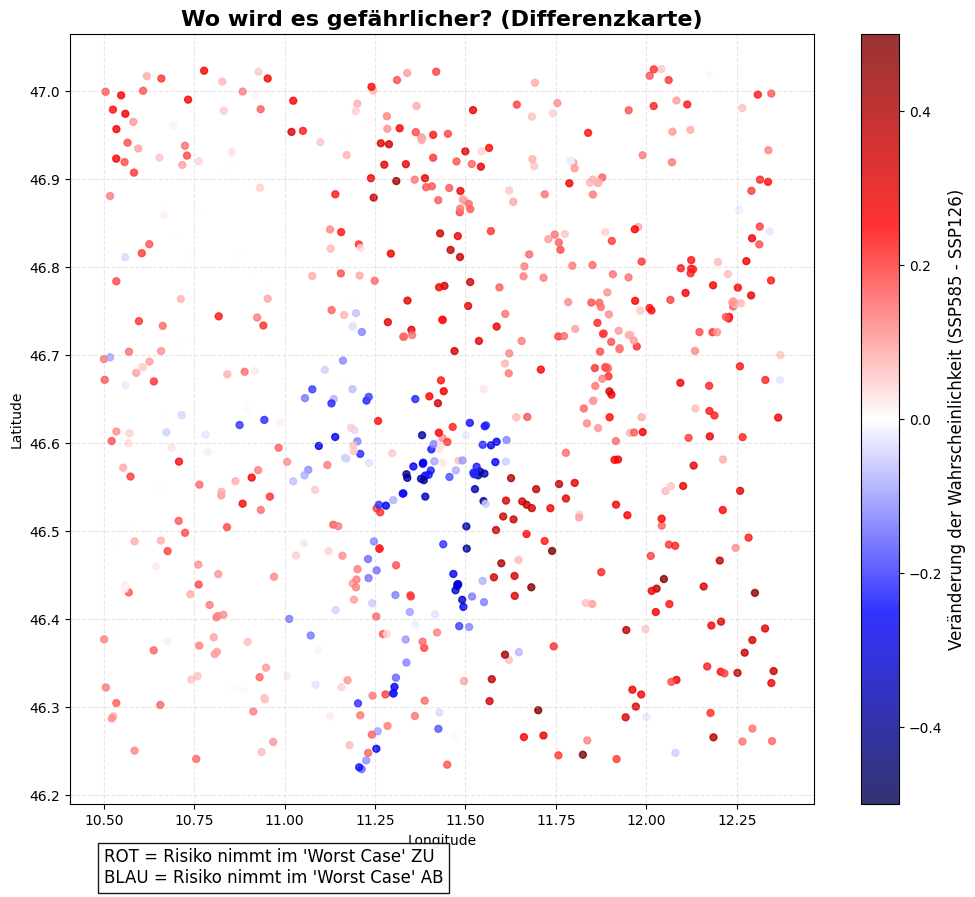

STATISTIK DER VERÄNDERUNG
Orte, an denen es gefährlicher wird (Diff > 0.1): 370
Orte, an denen es sicherer wird (Diff < -0.1):    85


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path_126 = '/content/drive/MyDrive/testNaturgefahren/RESULT_Risk_Map_2100_SSP126_PRUNED.csv'
path_585 = '/content/drive/MyDrive/testNaturgefahren/RESULT_Risk_Map_2100_SSP585_PRUNED.csv'

df_126 = pd.read_csv(path_126)
df_585 = pd.read_csv(path_585)

# Worst Case MINUS Best Case
df_126['Diff'] = df_585['Landslide_Probability'] - df_126['Landslide_Probability']

# Plotten
plt.figure(figsize=(12, 10))

# Farbskala: Rot = Risiko steigt, Blau = Risiko sinkt
cmap = "seismic"

# Scatterplot
sc = plt.scatter(
    df_126['Longitude'],
    df_126['Latitude'],
    c=df_126['Diff'],
    cmap=cmap,
    s=25,
    alpha=0.8,
    vmin=-0.5, vmax=0.5 # besserer Kontrast
)

cbar = plt.colorbar(sc)
cbar.set_label("Veränderung der Wahrscheinlichkeit (SSP585 - SSP126)", fontsize=12)

plt.title("Wo wird es gefährlicher? (Differenzkarte)", fontsize=16, fontweight='bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle='--', alpha=0.3)

# Text-Hinweis ins Bild
plt.text(10.5, 46.1, "ROT = Risiko nimmt im 'Worst Case' ZU\nBLAU = Risiko nimmt im 'Worst Case' AB",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

plt.show()

# Kurze Info dazu
print("STATISTIK DER VERÄNDERUNG")
print(f"Orte, an denen es gefährlicher wird (Diff > 0.1): {df_126[df_126['Diff'] > 0.1].shape[0]}")
print(f"Orte, an denen es sicherer wird (Diff < -0.1):    {df_126[df_126['Diff'] < -0.1].shape[0]}")

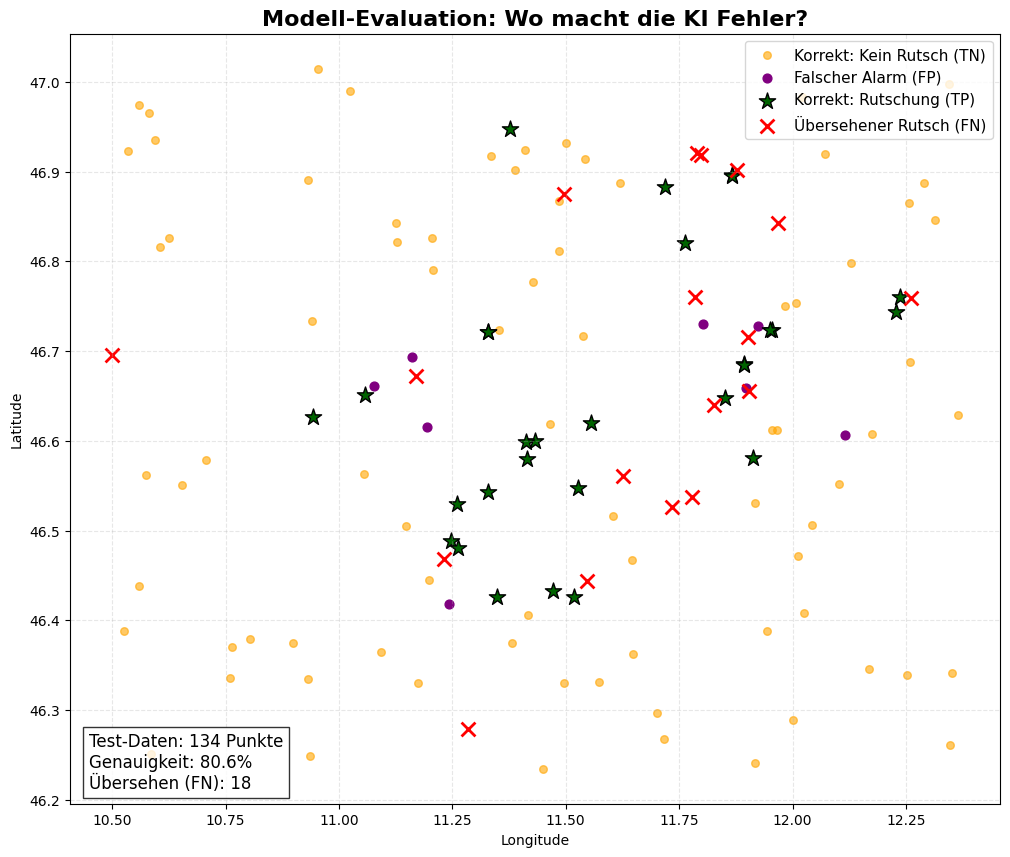

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clean_train_path = '/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_CLEAN.csv'
df = pd.read_csv(clean_train_path)

# Features & Target
features = [
    'Latitude', 'Longitude', 'Elevation', 'Slope',
    'BIO01_Historical_Mean', 'BIO05_Historical_Max', 'BIO06_Historical_Min',
    'BIO12_Historical_Prec', 'BIO13_Historical_Prec', 'BIO15_Historical_Prec'
]

X = df[features].fillna(0)
y = df['Target']

# Split (gleicher Random State wie beim Training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MODELL (PRUNED)
rf = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=4, random_state=42)
rf.fit(X_train, y_train)

# Vorhersage auf den Test-Daten
y_pred = rf.predict(X_test)

# Koordinaten der Test-Punkte
plot_df = X_test[['Longitude', 'Latitude']].copy()
plot_df['Actual'] = y_test
plot_df['Predicted'] = y_pred

# Kategorien bestimmen
def get_category(row):
    if row['Actual'] == 1 and row['Predicted'] == 1:
        return 'TP' # Correct Landslide (Richtig erkannt Rutsch)
    elif row['Actual'] == 0 and row['Predicted'] == 0:
        return 'TN' # Correct No-Slide (Richtig erkannt kein Rutsch)
    elif row['Actual'] == 0 and row['Predicted'] == 1:
        return 'FP' # False Alarm (Fehlalarm)
    elif row['Actual'] == 1 and row['Predicted'] == 0:
        return 'FN' # Missed Landslide (Übersehen!)
    return 'Error'

plot_df['Category'] = plot_df.apply(get_category, axis=1)

plt.figure(figsize=(12, 10))

# 1. Correct No-Slide (TN) -> Orange Punkte
tn = plot_df[plot_df['Category'] == 'TN']
plt.scatter(tn['Longitude'], tn['Latitude'], c='orange', s=30, alpha=0.6, label='Korrekt: Kein Rutsch (TN)')

# 2. False Alarm (FP) -> Lila Punkte
fp = plot_df[plot_df['Category'] == 'FP']
plt.scatter(fp['Longitude'], fp['Latitude'], c='purple', s=40, marker='o', label='Falscher Alarm (FP)')

# 3. Correct Landslide (TP) -> Grüne Sterne
tp = plot_df[plot_df['Category'] == 'TP']
plt.scatter(tp['Longitude'], tp['Latitude'], c='darkgreen', s=150, marker='*', edgecolors='black', label='Korrekt: Rutschung (TP)')

# 4. Missed Landslide (FN) -> Rotes Kreuz
fn = plot_df[plot_df['Category'] == 'FN']
plt.scatter(fn['Longitude'], fn['Latitude'], c='red', s=100, marker='x', linewidth=2, label='Übersehener Rutsch (FN)')

plt.title("Modell-Evaluation: Wo macht die KI Fehler?", fontsize=16, fontweight='bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right', frameon=True, fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)

# Statistik ins Bild schreiben
stat_text = (
    f"Test-Daten: {len(plot_df)} Punkte\n"
    f"Genauigkeit: {rf.score(X_test, y_test)*100:.1f}%\n"
    f"Übersehen (FN): {len(fn)}"
)
plt.text(0.02, 0.02, stat_text, transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

plt.show()

Fehler beim Laden des Shapefiles: C:\Users\richt\Desktop\testNaturgefahrenOhneBuffer\extent_UG\UG.shp: No such file or directory


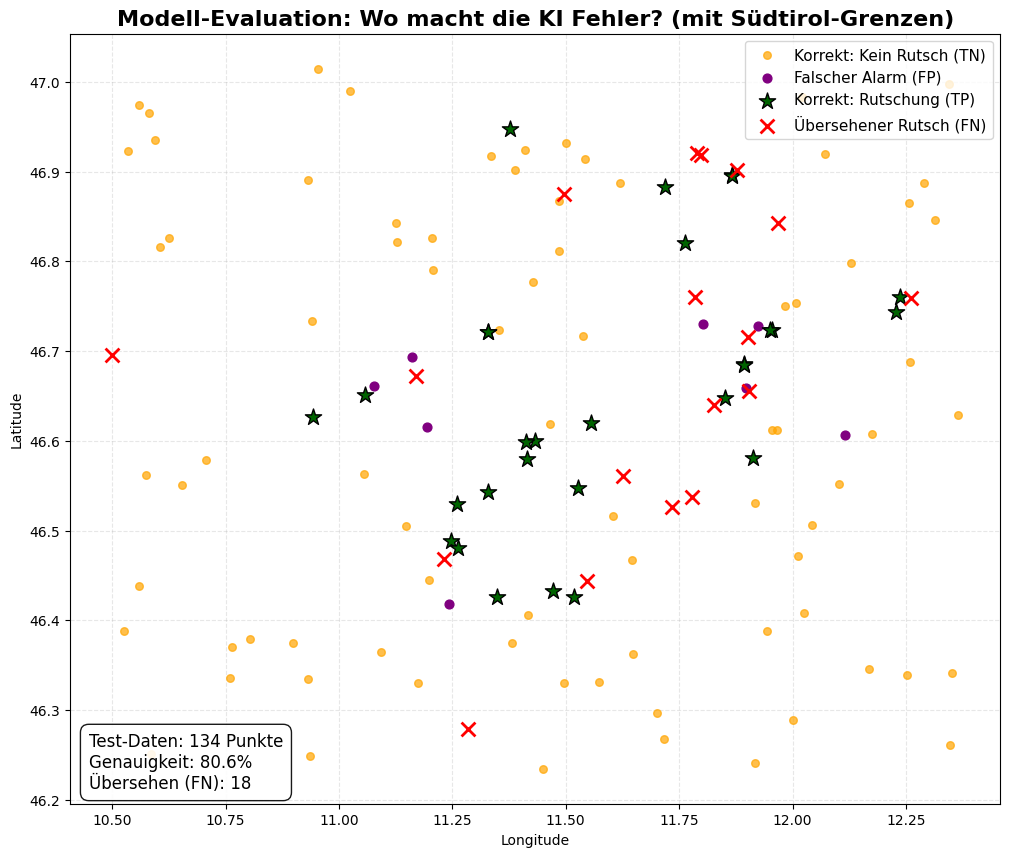

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import geopandas as gpd
#das hat nicht geklappt, weil noch falsches shapefile?! ÄNDERN NEU VERSUCHEN
clean_train_path = '/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_CLEAN.csv'

shapefile_path = r'C:\Users\richt\Desktop\testNaturgefahrenOhneBuffer\extent_UG\UG.shp'
# shapefile_path = '/content/drive/MyDrive/testNaturgefahren/UG.shp'

df = pd.read_csv(clean_train_path)

features = [
    'Latitude', 'Longitude', 'Elevation', 'Slope',
    'BIO01_Historical_Mean', 'BIO05_Historical_Max', 'BIO06_Historical_Min',
    'BIO12_Historical_Prec', 'BIO13_Historical_Prec', 'BIO15_Historical_Prec'
]
X = df[features].fillna(0)
y = df['Target']

# Exakt gleicher Split wie beim Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MODELL (PRUNED)
rf = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=4, random_state=42)
rf.fit(X_train, y_train)

# Vorhersage
y_pred = rf.predict(X_test)
accuracy = rf.score(X_test, y_test)

plot_df = X_test[['Longitude', 'Latitude']].copy()
plot_df['Actual'] = y_test
plot_df['Predicted'] = y_pred

def get_category(row):
    if row['Actual'] == 1 and row['Predicted'] == 1: return 'TP'
    elif row['Actual'] == 0 and row['Predicted'] == 0: return 'TN'
    elif row['Actual'] == 0 and row['Predicted'] == 1: return 'FP'
    elif row['Actual'] == 1 and row['Predicted'] == 0: return 'FN'
    return 'Error'

plot_df['Category'] = plot_df.apply(get_category, axis=1)

try:
    shp = gpd.read_file(shapefile_path)
    # Sicherstellen, dass das Shapefile im richtigen KOS ist (WGS84 für Lat/Lon)
    if shp.crs != 'EPSG:4326':
        shp = shp.to_crs('EPSG:4326')
    shapefile_loaded = True
except Exception as e:
    print(f"Fehler beim Laden des Shapefiles: {e}")
    shapefile_loaded = False

fig, ax = plt.subplots(figsize=(12, 10))

# 1. Shapefile plotten (als Hintergrund)
if shapefile_loaded:
    shp.plot(ax=ax, color='none', edgecolor='black', linewidth=1, zorder=1)

# 2. Punkte plotten
# TN (Orange)
tn = plot_df[plot_df['Category'] == 'TN']
ax.scatter(tn['Longitude'], tn['Latitude'], c='orange', s=30, alpha=0.7, label='Korrekt: Kein Rutsch (TN)', zorder=2)

# FP (Lila)
fp = plot_df[plot_df['Category'] == 'FP']
ax.scatter(fp['Longitude'], fp['Latitude'], c='purple', s=40, marker='o', label='Falscher Alarm (FP)', zorder=2)

# TP (Grüne Sterne)
tp = plot_df[plot_df['Category'] == 'TP']
ax.scatter(tp['Longitude'], tp['Latitude'], c='darkgreen', s=150, marker='*', edgecolors='black', label='Korrekt: Rutschung (TP)', zorder=3)

# FN (Rote Kreuze)
fn = plot_df[plot_df['Category'] == 'FN']
ax.scatter(fn['Longitude'], fn['Latitude'], c='red', s=100, marker='x', linewidth=2, label='Übersehener Rutsch (FN)', zorder=3)

# LAYOUT
ax.set_title("Modell-Evaluation: Wo macht die KI Fehler? (mit Südtirol-Grenzen)", fontsize=16, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc='upper right', frameon=True, fontsize=11)
ax.grid(True, linestyle='--', alpha=0.3)

# Statistik-Box
fn_count = len(fn)
stat_text = (
    f"Test-Daten: {len(plot_df)} Punkte\n"
    f"Genauigkeit: {accuracy*100:.1f}%\n"
    f"Übersehen (FN): {fn_count}"
)
ax.text(0.02, 0.02, stat_text, transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.5'), fontsize=12, zorder=4)

plt.show()

In [32]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
import zipfile
import os
import math

train_csv = '/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_CLEAN.csv'
proj_csv_126 = '/content/drive/MyDrive/testNaturgefahren/PREDICT_SSP126_READY.csv'
proj_csv_585 = '/content/drive/MyDrive/testNaturgefahren/PREDICT_SSP585_READY.csv'

temp_dir = '/content/temp_topo'
if not os.path.exists(temp_dir): os.makedirs(temp_dir)
elev_zip = f"{temp_dir}/elev.zip"
url = "https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_30s_elev.zip"

if not os.path.exists(elev_zip):
    print("Lade Elevation neu...")
    os.system(f"wget -q -c {url} -O {elev_zip}")

# Entpacken
with zipfile.ZipFile(elev_zip, 'r') as z:
    tif_name = [f for f in z.namelist() if f.endswith('.tif')][0]
    z.extract(tif_name, path=temp_dir)
    elev_tif = f"{temp_dir}/{tif_name}"

# Bounding Box Südtirol
bbox = box(10.0, 46.0, 13.0, 47.5)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs="EPSG:4326")

def add_aspect(csv_path):
    print(f"Bearbeite {os.path.basename(csv_path)}...")
    df = pd.read_csv(csv_path)
    coords = [(row['Longitude'], row['Latitude']) for _, row in df.iterrows()]

    with rasterio.open(elev_tif) as src:
        out_image, out_transform = mask(src, geo.geometry, crop=True)
        data = out_image[0].astype('float32')

        # Gradienten berechnen (wie bei Slope)
        res_x = out_transform[0]
        res_y = -out_transform[4]
        lat_mean = 46.5 * (math.pi / 180)
        scale_x = 111132 * math.cos(lat_mean) * res_x
        scale_y = 111132 * res_y

        dy, dx = np.gradient(data)

        # Aspect ist die Richtung des Gefälles (0-360 Grad)
        # arctan2(dy, -dx) gibt Bogenmaß
        aspect_rad = np.arctan2(-dx, dy) # Minus dx wegen Koordinatensystem-Besonderheiten bei Grids
        aspect_deg = np.degrees(aspect_rad)

        # Umrechnung: Norden=0, Osten=90...
        # arctan2 gibt -180 bis 180. aber will 0 bis 360
        aspect_deg = np.where(aspect_deg < 0, aspect_deg + 360, aspect_deg)

        # Speichern & Samplen
        meta = src.meta.copy()
        meta.update({"driver": "GTiff", "height": data.shape[0], "width": data.shape[1], "transform": out_transform})

        aspect_tif = f"{temp_dir}/temp_aspect.tif"
        with rasterio.open(aspect_tif, 'w', **meta) as dst:
            dst.write(aspect_deg, 1)

        with rasterio.open(aspect_tif) as a_src:
            df['Aspect'] = [x[0] for x in a_src.sample(coords)]

    df.to_csv(csv_path, index=False)
    print(" -> Aspect hinzugefügt.")

# Ausführen für alle 3 Dateien
add_aspect(train_csv)
add_aspect(proj_csv_126)
add_aspect(proj_csv_585)

print("\nFertig! Jetzt weiß das Modell auch, ob der Hang nach Norden oder Süden zeigt.")

Bearbeite landslides_TRAINING_CLEAN.csv...
 -> Aspect hinzugefügt.
Bearbeite PREDICT_SSP126_READY.csv...
 -> Aspect hinzugefügt.
Bearbeite PREDICT_SSP585_READY.csv...
 -> Aspect hinzugefügt.

Fertig! Jetzt weiß das Modell auch, ob der Hang nach Norden oder Süden zeigt.


In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

clean_train_path = '/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_CLEAN.csv'

df = pd.read_csv(clean_train_path)

# mit Aspect, aber ohne Lat/Lon
features_physic = [
    'Elevation',
    'Slope',
    'Aspect',  # neu
    'BIO01_Historical_Mean',
    'BIO05_Historical_Max',
    'BIO06_Historical_Min',
    'BIO12_Historical_Prec',
    'BIO13_Historical_Prec',
    'BIO15_Historical_Prec'
]

# Prüfen ob Aspect wirklich da ist (falls das vorige Skript geklappt hat)
if 'Aspect' not in df.columns:
    print("WARNUNG: 'Aspect' fehlt in der CSV! provisorisch mit 0 fpllen, damit der Test läuft.")
    df['Aspect'] = 0

X = df[features_physic].fillna(0)
y = df['Target']

# Split (Gleicher Seed für Fairness)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TRAINING (PRUNED)
print("Trainiere Modell (ohne Koordinaten)...")
rf_physic = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=4, random_state=42)
rf_physic.fit(X_train, y_train)

# ERGEBNISSE
acc = rf_physic.score(X_test, y_test)

print(f"\n TEST-ERGEBNIS")
print(f"Genauigkeit ohne Lat/Lon: {acc*100:.2f}%")
# Zum Vergleich: Vorher waren es ca. 80.6%

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rf_physic.predict(X_test)))

print("WAS IST JETZT WICHTIG? (Feature Importance)")
importances = pd.Series(rf_physic.feature_importances_, index=features_physic).sort_values(ascending=False)
print(importances)

# Fazit
if acc > 0.75:
    print("\n Das Modell funktioniert auch ohne Koordinaten. gut!")
elif acc > 0.70:
    print("\n Es hat etwas verloren, aber ist noch brauchbar.")
else:
    print("\n VORSICHT. Die Genauigkeit ist stark gesunken. Lat/Lon waren sehr wichtig.")

Trainiere Modell (ohne Koordinaten)...

 TEST-ERGEBNIS
Genauigkeit ohne Lat/Lon: 79.85%

Confusion Matrix:
[[80  7]
 [20 27]]

--- WAS IST JETZT WICHTIG? (Feature Importance) ---
Elevation                0.164852
BIO01_Historical_Mean    0.164523
BIO05_Historical_Max     0.130615
BIO06_Historical_Min     0.105054
BIO13_Historical_Prec    0.098813
BIO15_Historical_Prec    0.096506
BIO12_Historical_Prec    0.094983
Aspect                   0.077127
Slope                    0.067526
dtype: float64

 Das Modell funktioniert auch ohne Koordinaten. gut!


In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive

# drive.mount('/content/drive')

train_path = '/content/drive/MyDrive/testNaturgefahren/landslides_TRAINING_CLEAN.csv'
pred_126 = '/content/drive/MyDrive/testNaturgefahren/PREDICT_SSP126_READY.csv'
pred_585 = '/content/drive/MyDrive/testNaturgefahren/PREDICT_SSP585_READY.csv'

# Output
res_126 = '/content/drive/MyDrive/testNaturgefahren/RESULT_FINAL_SSP126.csv'
res_585 = '/content/drive/MyDrive/testNaturgefahren/RESULT_FINAL_SSP585.csv'

# mit Aspect, aber ohne Lat/Lon
features = [
    'Elevation', 'Slope', 'Aspect',
    'BIO01_Historical_Mean', 'BIO05_Historical_Max', 'BIO06_Historical_Min',
    'BIO12_Historical_Prec', 'BIO13_Historical_Prec', 'BIO15_Historical_Prec'
]

print("1. Lade Daten & Trainiere Modell...")
df = pd.read_csv(train_path)

# Aspect sicherstellen (falls NaN -> 0)
df['Aspect'] = df.get('Aspect', 0)
X = df[features].fillna(0)
y = df['Target']

# Finales Training alle Daten!!
rf_final = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=4, random_state=42)
rf_final.fit(X, y)
print("   -> Modell trainiert.")

# 2. PROGNOSE 2100
def run_prediction(in_path, out_path, name):
    print(f"2. Berechne {name}...")
    df_fut = pd.read_csv(in_path)

    if 'Aspect' not in df_fut.columns:
        print("   Warnung: Aspect fehlt in Prediction-File. Setze auf 0.")
        df_fut['Aspect'] = 0

    X_fut = df_fut[features].fillna(0)

    # Wahrscheinlichkeit
    probs = rf_final.predict_proba(X_fut)[:, 1]
    df_fut['Landslide_Probability'] = probs

    # Klassen
    df_fut['Risk_Class'] = df_fut['Landslide_Probability'].apply(
        lambda x: 'HOCH' if x >= 0.7 else ('MITTEL' if x >= 0.3 else 'NIEDRIG')
    )

    df_fut.to_csv(out_path, index=False)
    print(f"   -> Gespeichert: {out_path}")

run_prediction(pred_126, res_126, "SSP126 (Optimistisch)")
run_prediction(pred_585, res_585, "SSP585 (Pessimistisch)")

print("\nFERTIG!")

1. Lade Daten & Trainiere Modell...
   -> Modell trainiert.
2. Berechne SSP126 (Optimistisch)...
   -> Gespeichert: /content/drive/MyDrive/testNaturgefahren/RESULT_FINAL_SSP126.csv
2. Berechne SSP585 (Pessimistisch)...
   -> Gespeichert: /content/drive/MyDrive/testNaturgefahren/RESULT_FINAL_SSP585.csv

FERTIG!
